# 6.21, 6.26 감성분석 실습 Sentiment Analysis
### opinion extraction
### opinion mining
### sentiment mining
### subjectivity meani
### 감성 <-> 감정
### shallow feeling <-> strong feeling

# 네이버 - 영화 -> 영화평 수집

In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time

In [2]:
browser = webdriver.Chrome()
url = "https://movie.naver.com/movie/point/af/list.nhn"
browser.get(url)

In [ ]:
from tqdm import tqdm
reviewData = list()
# links = browser.find_element_by_class_name('paging').find_elements_by_tag_name('a')
_iter = 100
for page in range(_iter):
    for row in browser.find_elements_by_tag_name('tr')[1:]:
        title = row.find_element_by_class_name('title').text.split('\n')[0]
        point = row.find_element_by_class_name('point').text
        text = row.find_element_by_class_name('title').text.split('\n')[1][:-3]
        reviewData.append((title, point, text))
    browser.find_element_by_class_name('pg_next').click()

In [ ]:
import csv

csvFile = open("./reviewData.csv", "a", newline="\n")
csvWriter = csv.writer(csvFile)

for row in reviewData:
    csvWriter.writerow(row)

csvFile.close()

In [ ]:
reviewData[-1]

# 데이터 가져오기

In [4]:
import pandas as pd
reviews = pd.read_csv("./reviewData.csv", header=None,
                         names = ["name", "score", "review"], encoding = 'cp949')

In [5]:
reviews = reviews.drop_duplicates()

In [6]:
reviews = reviews[['score', 'review']]

In [7]:
reviews.groupby(['score'])

# PMI

###  positive review : 7 ~ 9

In [8]:
positive = reviews[(reviews['score'] > 7) & (reviews["score"] < 10)]

###  negative review : < 4

In [9]:
negative = reviews[reviews['score'] < 4]

In [10]:
posN = len(positive)
negN = len(negative)
N = len(reviews) # hits(N)

# P(Y=neg) = hits(Y=neg)/hits(N)
# P(Y=Pos) = hits(Y=pos)/hits(N)
positive.count(), negative.count()


(score     1566
 review    1566
 dtype: int64, score     1552
 review    1552
 dtype: int64)

In [11]:
from collections import Counter, defaultdict
# counter는 value가 정렬 되어있음
from konlpy.tag import Komoran

ma = Komoran()

In [12]:
posDTM = defaultdict(Counter)
for i, review in positive.iterrows():
#     print(i, review)
    for pos in ma.pos(review['review']): # tuple(형태소, 품사)
        if len(pos[0]) > 1:
            posDTM[i][pos] += 1
            
negDTM = defaultdict(Counter)
for i, review in negative.iterrows():
    for pos in ma.pos(review['review']): # tuple(형태소, 품사)
        if len(pos[0]) > 1:
            negDTM[i][pos] += 1

In [13]:
posTDM = defaultdict(Counter)
for i, posList in posDTM.items():
    for t, freq in posList.items():
        posTDM[t][i] = freq
        
negTDM = defaultdict(Counter)
for i, negList in negDTM.items():
    for t, freq in negList.items():
        negTDM[t][i] = freq

In [14]:
# PMI(x=uniqTerm, y=Pos/Neg)
posVoca = list(posTDM.keys())
negVoca = list(negTDM.keys())

In [15]:
posPOS = defaultdict(Counter)
for t in posVoca:
    posPOS[t[1]][t[0]] = sum(posTDM[t].values())
    
negPOS = defaultdict(Counter)
for t in negVoca:
    negPOS[t[1]][t[0]] = sum(negTDM[t].values())

In [16]:
list(zip(posPOS['NNG'].most_common()[:20],
       negPOS['NNG'].most_common()[:20]))

[(('영화', 480), ('영화', 576)),
 (('생각', 117), ('평점', 108)),
 (('연기', 81), ('시간', 62)),
 (('기대', 60), ('사람', 60)),
 (('사람', 48), ('감독', 59)),
 (('감동', 44), ('내용', 55)),
 (('내용', 38), ('최악', 52)),
 (('현실', 37), ('기대', 44)),
 (('사랑', 36), ('생각', 44)),
 (('배우', 36), ('연기', 38)),
 (('마지막', 36), ('재미', 37)),
 (('시간', 36), ('배우', 35)),
 (('재미', 35), ('개연', 34)),
 (('감독', 35), ('처음', 33)),
 (('평점', 34), ('수준', 32)),
 (('느낌', 33), ('이해', 28)),
 (('마음', 31), ('마지막', 27)),
 (('작품', 31), ('정도', 26)),
 (('중간', 30), ('중간', 26)),
 (('노래', 28), ('진짜', 26))]

In [17]:
ma.tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NA': '분석불능범주',
 'NF': '명사추정범주',
 'NNB': '의존 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'NV': '용언추정범주',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

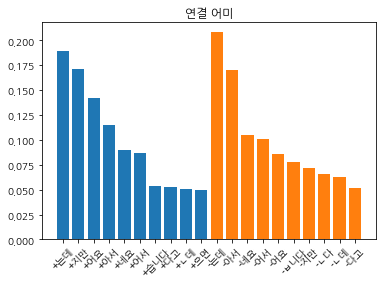

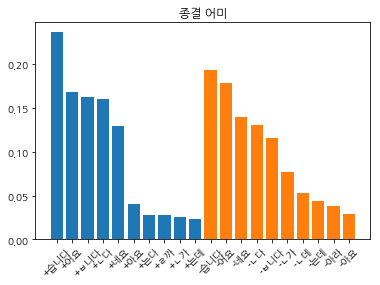

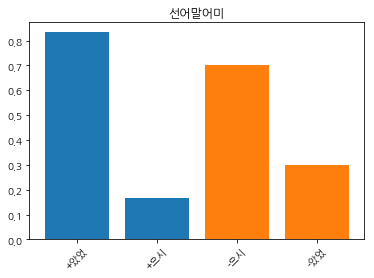

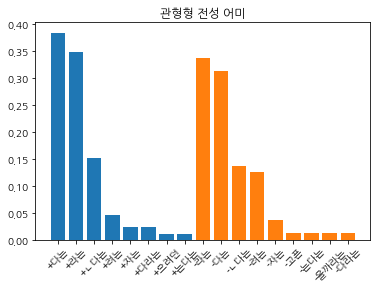

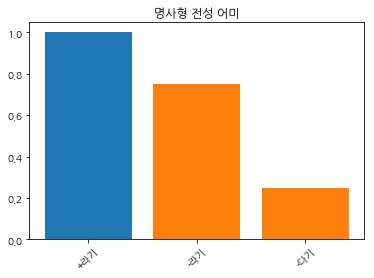

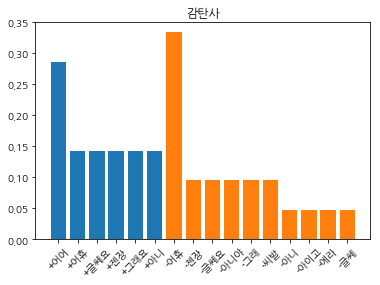

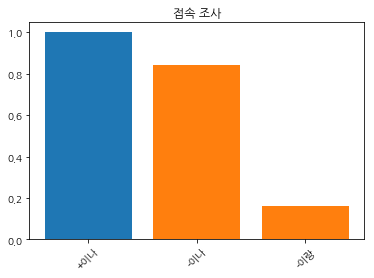

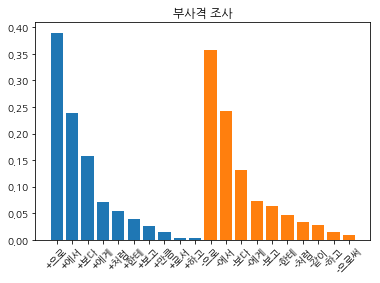

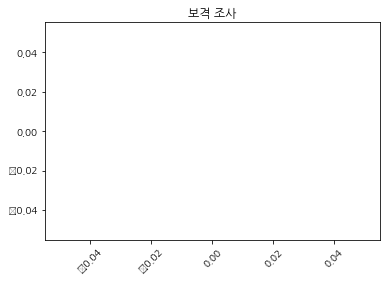

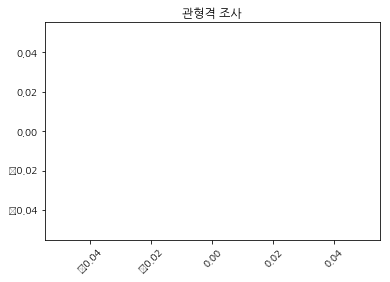

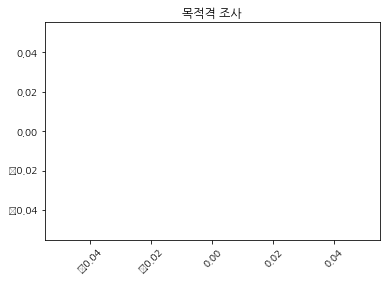

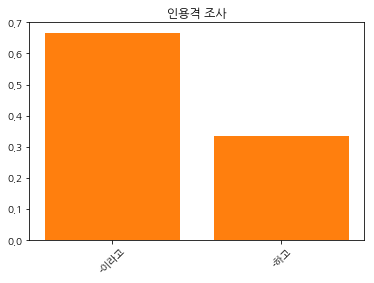

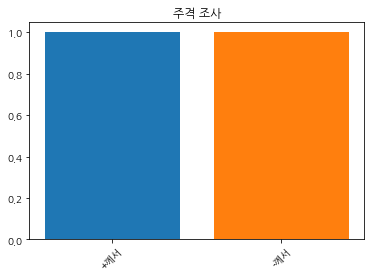

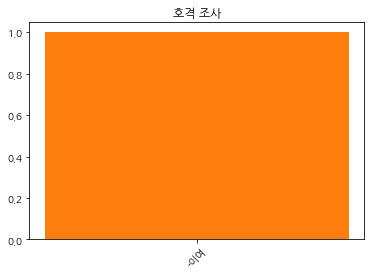

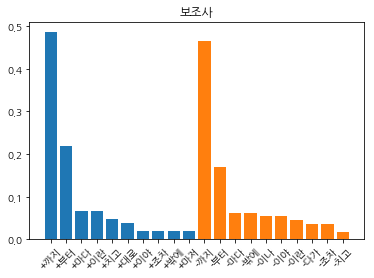

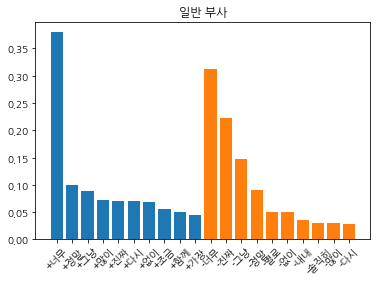

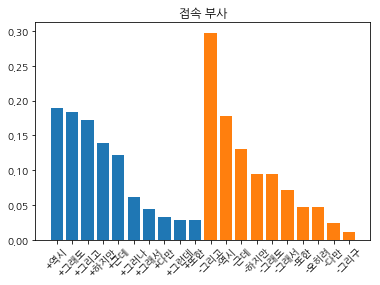

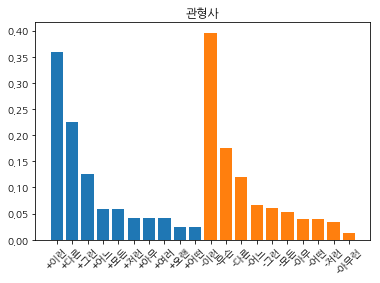

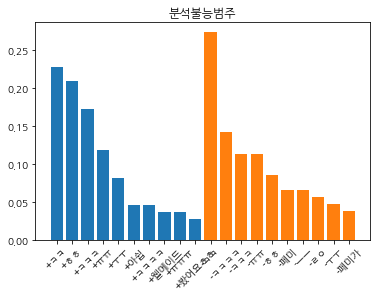

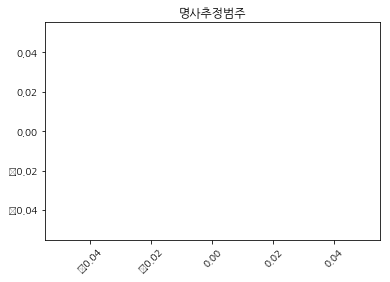

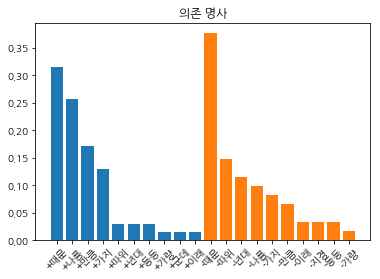

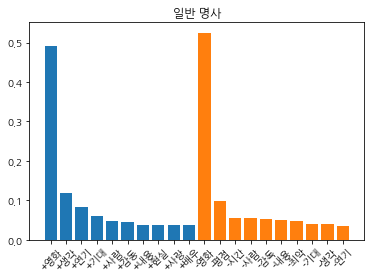

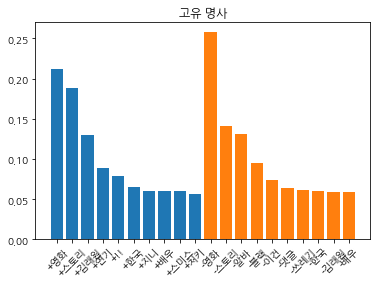

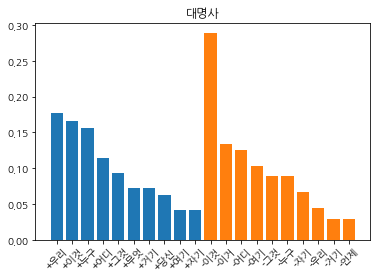

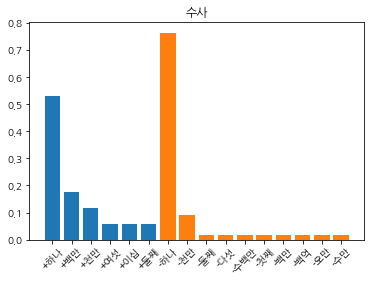

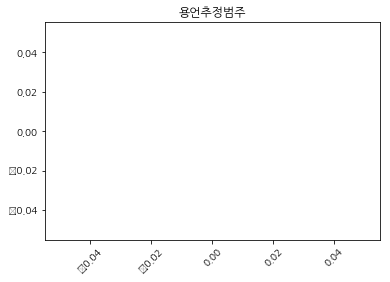

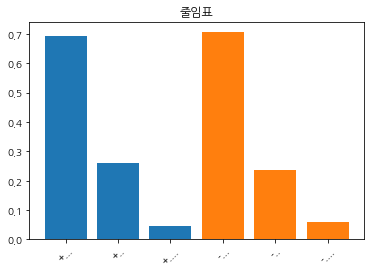

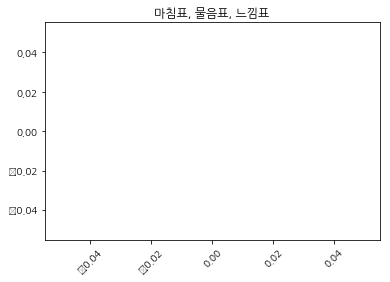

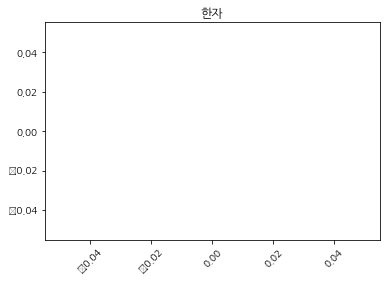

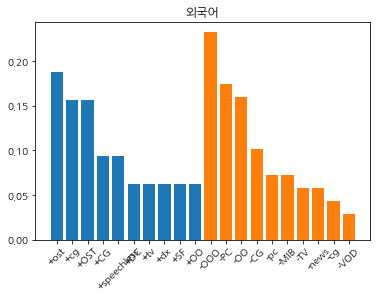

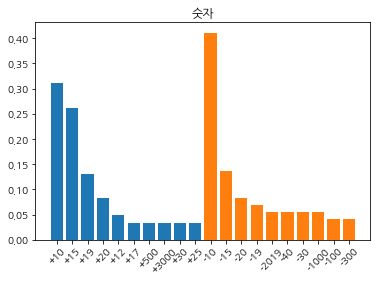

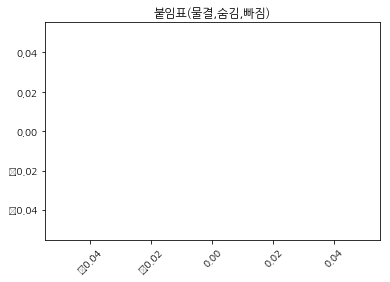

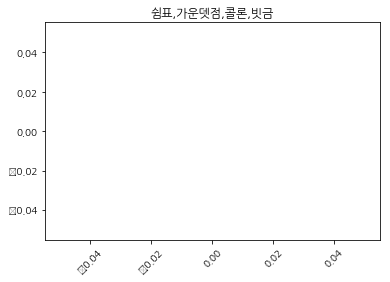

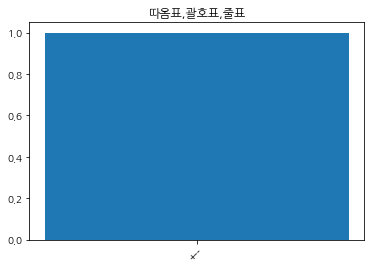

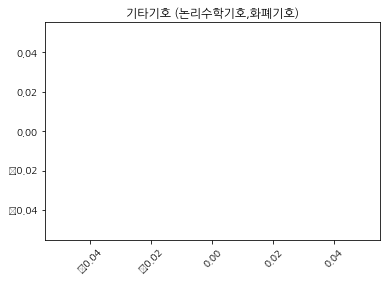

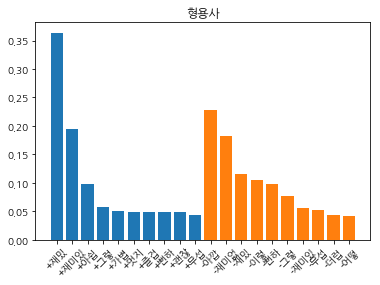

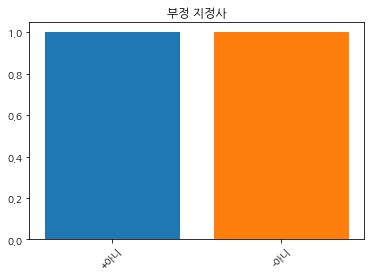

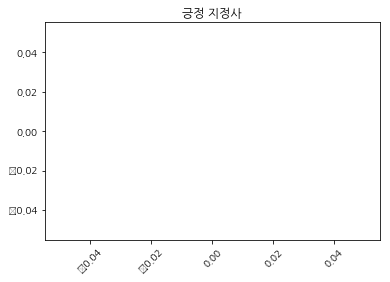

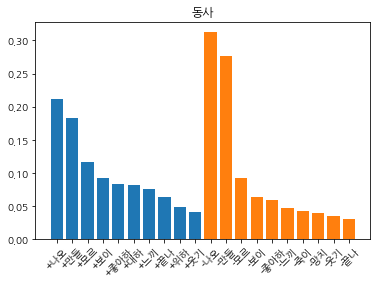

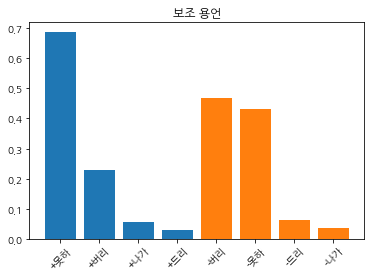

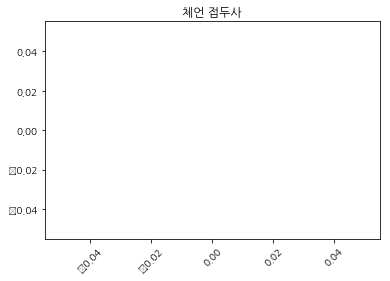

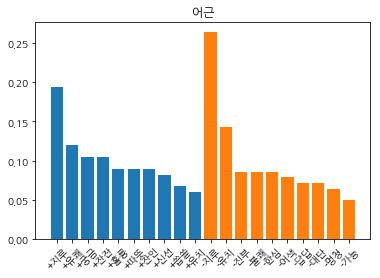

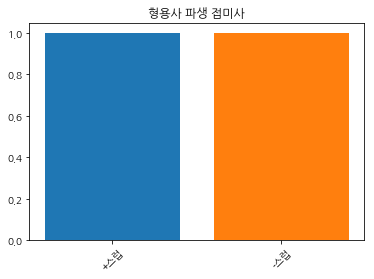

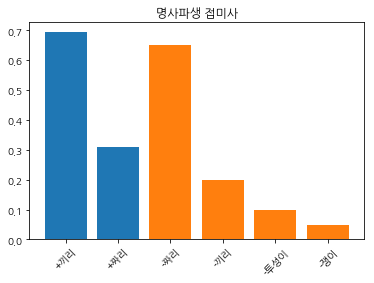

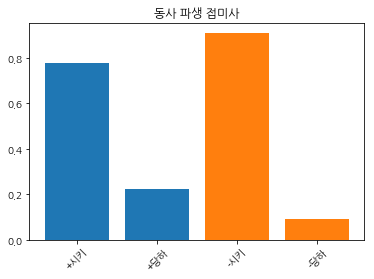

In [32]:
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()

rc('font',family=font_name)

for pos, kor in ma.tagset.items():
    _pos = posPOS[pos].most_common()[:10]
    _neg = negPOS[pos].most_common()[:10]
    _posSum = sum([_[1] for _ in _pos])
    _negSum = sum([_[1] for _ in _neg])

    # x축 키값 y축 빈도 
    plt.bar(["+" + _[0] for _ in _pos], [_[1]/_posSum for _ in _pos])
    plt.bar(["-" + _[0] for _ in _neg], [_[1]/_negSum for _ in _neg])
    plt.title(kor)
    plt.xticks(rotation=45)
    plt.show()

In [19]:
from math import log

N = posN + negN
posY = posN / N
negY = negN / N
posPMI = defaultdict(float)
negPMI = defaultdict(float)
posNPMI = defaultdict(float)
negNPMI = defaultdict(float)


for t in list(set(posVoca + negVoca)):
    posX = (len(posTDM[t]) + 
               len(negTDM[t])) / N
    posXY = (len(posTDM[t]) + 0.1) / N
    negXY = (len(negTDM[t]) + 0.1) / N

    posPMI[t] = log(posXY / (posX * posY))
    negPMI[t] = log(negXY / (posX * posY))
    
    posNPMI[t] = posPMI[t] / -log(posXY) 
    negNPMI[t] = negPMI[t] / -log(posXY)
# PMI(x, y=pos)
# P(y=pos) = posN / N

In [20]:
sorted(posPMI.items(), key=lambda x:x[1], reverse=True)[:20]

[(('단정', 'XR'), 0.7839773528712984),
 (('엄마와 아빠', 'NNP'), 0.7839773528712984),
 (('재밋다ㅜㅜ', 'NA'), 0.7839773528712984),
 (('구수', 'XR'), 0.7839773528712984),
 (('다이너마이트', 'NNP'), 0.7839773528712984),
 (('옆모습', 'NNG'), 0.7839773528712984),
 (('걍..ㅎㅎ', 'NA'), 0.7839773528712984),
 (('언터처블', 'NNP'), 0.7839773528712984),
 (('클라라', 'NNP'), 0.7839773528712984),
 (('다이하드', 'NNP'), 0.7839773528712984),
 (('열리', 'VV'), 0.7839773528712984),
 (('이벤트', 'NNP'), 0.7839773528712984),
 (('한구석', 'NNG'), 0.7839773528712984),
 (('무관', 'NNG'), 0.7839773528712984),
 (('ㅅㅂ...', 'NA'), 0.7839773528712984),
 (('야쿠자', 'NNP'), 0.7839773528712984),
 (('쨩쨩맨', 'NA'), 0.7839773528712984),
 (('비치', 'VV'), 0.7839773528712984),
 (('난민', 'NNP'), 0.7839773528712984),
 (('동창회', 'NNG'), 0.7839773528712984)]

In [21]:
#SO(t) = PMI(t, POSITIVE) - PMI(t, NEGATIVE)  # if 0 > POSITVE ELSE NEGATIVE
posSO = defaultdict(float)
negSO = defaultdict(float)
posNSO = defaultdict(float)
negNSO = defaultdict(float)

for t in list(set(posVoca + negVoca)):
    posSO[t] = posPMI[t] - negPMI[t]
    negSO[t] = negPMI[t] - posPMI[t]
    posNSO[t] = posNPMI[t] - negNPMI[t]
    negNSO[t] = negNPMI[t] - posNPMI[t]

In [22]:
sorted(posSO.items(), key=lambda x:x[1], reverse=True)[:20]

[(('유쾌', 'XR'), 5.081404364984463),
 (('잔잔', 'XR'), 4.948759890378168),
 (('행복', 'NNG'), 4.875197323201151),
 (('귀엽', 'VA'), 4.875197323201151),
 (('아름답', 'VA'), 4.795790545596741),
 (('그러나', 'MAJ'), 4.709530201312334),
 (('따뜻', 'XR'), 4.709530201312334),
 (('순수', 'NNG'), 4.61512051684126),
 (('살짝', 'MAG'), 4.61512051684126),
 (('살아가', 'VV'), 4.51085950651685),
 (('아들', 'NNG'), 4.51085950651685),
 (('씁쓸', 'XR'), 4.51085950651685),
 (('군가', 'NNP'), 4.394449154672439),
 (('만큼', 'JKB'), 4.2626798770413155),
 (('재밌는 영화', 'NNP'), 4.2626798770413155),
 (('뛰어나', 'VA'), 4.2626798770413155),
 (('자막', 'NNP'), 4.2626798770413155),
 (('다시', 'NNP'), 4.2626798770413155),
 (('ost', 'SL'), 4.110873864173311),
 (('다만', 'NNP'), 4.110873864173311)]

In [23]:
sorted(negSO.items(), key=lambda x:x[1], reverse=True)[:20]

[(('이거', 'NP'), 5.198497031265825),
 (('망치', 'VV'), 5.14166355650266),
 (('정은지', 'NNP'), 5.017279836814924),
 (('낭비', 'NNG'), 4.795790545596741),
 (('죄다', 'MAG'), 4.61512051684126),
 (('짜증', 'NNP'), 4.61512051684126),
 (('어이', 'NNP'), 4.51085950651685),
 (('어야지', 'EC'), 4.51085950651685),
 (('PC', 'SL'), 4.394449154672439),
 (('개도', 'NNP'), 4.394449154672439),
 (('페미', 'NA'), 4.2626798770413155),
 (('ㅡㅡ', 'NA'), 4.2626798770413155),
 (('감성', 'NNP'), 4.2626798770413155),
 (('ㄴ다고', 'EC'), 4.110873864173311),
 (('조르', 'VV'), 4.110873864173311),
 (('겁나', 'VV'), 4.110873864173311),
 (('이하', 'NNG'), 4.110873864173311),
 (('열심히', 'MAG'), 4.110873864173311),
 (('대충', 'MAG'), 4.110873864173311),
 (('악의', 'NNP'), 4.110873864173311)]

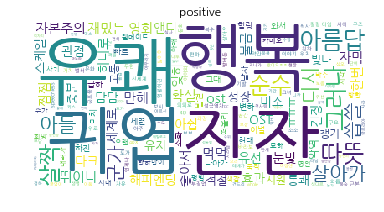

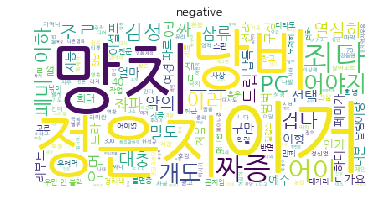

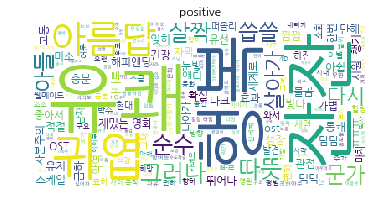

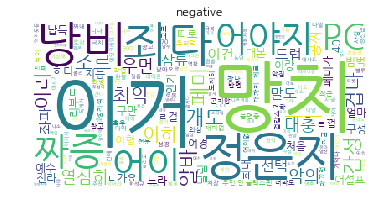

In [24]:
from wordcloud import WordCloud
wc = WordCloud(font_path="c:/Windows/Fonts/NanumGothic.ttf",
              background_color="white")

wc.generate_from_frequencies({t[0]:so for t, so in posSO.items()})
# wc.to_image()
plt.imshow(wc.to_array())
plt.title("positive")
plt.axis("off")
plt.show()

wc.generate_from_frequencies({t[0]:so for t, so in negSO.items()})
plt.imshow(wc.to_array())
plt.axis("off")
plt.title("negative")
plt.show()

# 정규화
wc.generate_from_frequencies({t[0]:so for t, so in posNSO.items()})
# wc.to_image()
plt.imshow(wc.to_array())
plt.title("positive")
plt.axis("off")
plt.show()

wc.generate_from_frequencies({t[0]:so for t, so in negNSO.items()})
plt.imshow(wc.to_array())
plt.axis("off")
plt.title("negative")
plt.show()

# seed사용한 PMI

In [25]:
TDM = defaultdict(lambda: defaultdict(int))
Vocabulary = list()
for i, review in positive.iterrows():
    for pos in ma.pos(review['review']): # tuple(형태소, 품사)
        if len(pos[0]) > 1 and pos[1] in ["NNG", "NNP"]:
            TDM[pos[0]][i] += 1
            Vocabulary.append(pos[0])
Vocabulary = list(set(Vocabulary))

In [26]:
from math import log

pSeeds = ["감동", "최고", "행복"]
nSeeds = ["쓰레기", "억지", "최악"]

N = len(reviews)
smoothing = 0.1

positivePMI = defaultdict(lambda: defaultdict(float))
positiveNPMI = defaultdict(lambda: defaultdict(float))

negativePMI = defaultdict(lambda: defaultdict(float))
negativeNPMI = defaultdict(lambda: defaultdict(float))

for seed in pSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in Vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        positivePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        positiveNPMI[term][seed] = positivePMI[term][seed]/-log(jointLikelihood)
        

for seed in nSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in Vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        negativePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        negativeNPMI[term][seed] = negativePMI[term][seed]/-log(jointLikelihood)

In [27]:
pmiSO = defaultdict(float)
npmiSO = defaultdict(float)

for term in Vocabulary:
    positivePmiSum = 0.0
    positiveNpmiSum = 0.0
    
    negativePmiSum = 0.0
    negativeNpmiSum = 0.0    
    
    for seed in pSeeds:
        positivePmiSum += positivePMI[term][seed]
        positiveNpmiSum += positiveNPMI[term][seed]
        
    for seed in nSeeds:
        negativePmiSum += negativePMI[term][seed]
        negativeNpmiSum += negativeNPMI[term][seed]
        
    pmiSO[term] = positivePmiSum - negativePmiSum
    npmiSO[term] = positiveNpmiSum - negativeNpmiSum

In [28]:
positivePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

positiveNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativeNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

긍정-PMI
['연기', '배우', '스토리', '감동', '토이', '연출', '노래', '영화', '행복', '한국', '걱정', '지니', '디즈니', '버전', '음악', '멜로물', '감정이입', '장면', '기분', '추억', '김래원', '제가', '재미', '몰입', '생각', '느낌', '내용', '용기', '가족', '주인공']


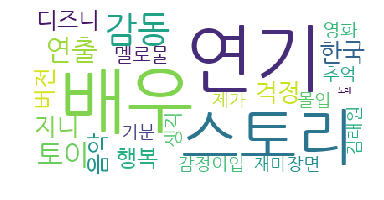

부정-PMI
['제이 코트니', '이상의', '김기덕', '다이하드', '저예산 영화', '취급', '계기', '진한', '도면', '존중', '홍상수', '우정', '캐스팅', '불편', '상황', '아픔', '너머', '다음', '눈물', '정신', '후반부', '평가', '!!!', '이정', '바탕', '각성', '생명', '형제', '작품', '쓰레기']


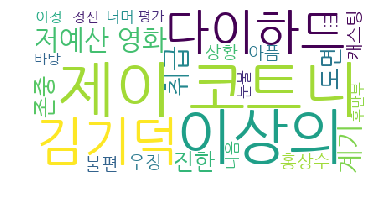

긍정-NPMI
['배우', '연기', '감동', '스토리', '행복', '토이', '연출', '멜로물', '노래', '제가', '디즈니', '버전', '걱정', '영화', '감정이입', '추억', '기분', '최고', '지니', '음악', '몰입', '한국', '장면', '김래원', '재미', '미국', '내용', '용기', '느낌', '전작']


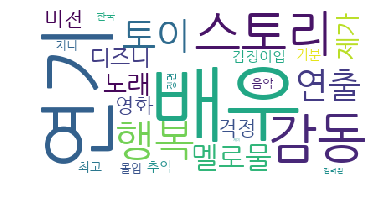

부정-NPMI
['불편', '눈물', '!!!', '우정', '다음', '후반부', '평가', '상황', '이정', '바탕', '정신', '각성', '형제', '캐스팅', '생명', '홍상수', '너머', '존중', '아픔', '이상의', '김기덕', '저예산 영화', '취급', '계기', '진한', '도면', '제이 코트니', '다이하드', '작품', '쓰레기']


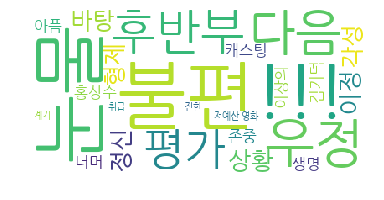

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="c:/Windows/Fonts/NanumGothic.ttf", background_color="white", max_words=25)

for termList, name in zip([positivePmiList, negativePmiList, positiveNpmiList, negativeNpmiList], ["긍정-PMI", "부정-PMI", "긍정-NPMI", "부정-NPMI"]):
    print(name)
    print([term[0] for term in sorted(termList.items(), key=lambda x:x[1], reverse=True)])
    wc.generate_from_frequencies(termList)
    plt.imshow(wc.to_array())
#     plt.rcParams["figure.figsize"] = (7,5)
    plt.axis("off")
    plt.show()